# Aprendizado de Máquina com Duplo Desviés (*Double Debiased Machine Learning* - DDML)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo
* Introdução
* Post-Double Selection (Seleção Pós-Dupla)
* 
* Cross-Validation (Validação Cruzada)
  * The Validation Set Approach (A Abordagem do Conjunto de Validação)
  * Leave-One-Out Cross-Validation (Validação Cruzada Leave-One-Out)
  * k-Fold Cross-Validation (Validação Cruzada k-Fold)
* The Bootstrap

### Referências

* [An Introduction to Statistical Learning](https://www.statlearning.com/) (ISL) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
  * Capítulo 5***
* [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) (ESL) by Trevor Hastie, Robert Tibshirani and Jerome Friedman : 
  * Capítulo 7

***Disclaimer:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

Configuração do sistema


In [10]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

repetir em caso de erro:

In [16]:
import types
import sys
import requests

# Cria um módulo fictício chamado 'dgp' na memória do computador
dgp_module = types.ModuleType("dgp")

# Executa o conteúdo de dgp.py e coloca dentro do módulo 'dgp'
dgp_code = requests.get("https://raw.githubusercontent.com/Daniel-Uhr/ComputationalEconomics_Notes/main/dgp/dgp.py").text
exec(dgp_code, dgp_module.__dict__)

# Registra o módulo no sys.modules para que outros códigos possam importá-lo
sys.modules["dgp"] = dgp_module

In [17]:
# Agora podemos carregar dgp_collection.py que depende de 'from dgp import DGP'
collection_code = requests.get("https://raw.githubusercontent.com/Daniel-Uhr/ComputationalEconomics_Notes/main/dgp/dgp_collection.py").text
exec(collection_code)

In [21]:
figures = requests.get("https://raw.githubusercontent.com/Daniel-Uhr/ComputationalEconomics_Notes/main/dgp/figures.py").text
exec(figures)

ModuleNotFoundError: No module named 'gif'

In [20]:
theme = requests.get("https://raw.githubusercontent.com/Daniel-Uhr/ComputationalEconomics_Notes/main/dgp/theme.py").text
exec(theme)

### Introdução

Em um experimento controlado e aleatorizado (*Randomized Controlled Trial* - RCT), o tratamento ($D$) é aleatoriamente atribuído aos participantes, o que permite que os pesquisadores isolem o efeito do tratamento sobre o resultado. E o uso de variáveis de controle ($X$) é geralmente desnecessário, pois a aleatorização garante que os grupos de tratamento e controle sejam comparáveis em todas as características observadas e não observadas. Logo, a utilização das variáveis de controle teria um papel secundário, como o de aumentar o poder estatístico da análise, ao reduzir a variância do estimador.

Em estudos observacionais, onde não há aleatorização do tratamento, o uso de variáveis de controle torna-se essencial para tentar recuperar os efeitos causais. Nesse contexto, as variáveis de controle são utilizadas para ajustar as diferenças pré-existentes entre os grupos de tratamento e controle, permitindo uma melhor aproximação do efeito causal.

Em muitos casos, o pesquisador dispõe de um grande número de variáveis de controle, e surge a necessidade de selecionar aquelas mais relevantes, eventualmente capturando não linearidades e interações. Algoritmos de aprendizado de máquina são particularmente adequados para essa tarefa. No entanto, nesses casos, estamos introduzindo um viés chamado de regularização ou pré-teste (Regularization - Pre-test), ou viés de seleção de características. 

Nesta aula, examinaremos a origem desse viés e apresentaremos uma das soluções mais influentes na última década na interseção entre aprendizado de máquina e inferência causal: o **Aprendizado de Máquina com Duplo Desviés** (*Double Debiased Machine Learning - DDML*).



### Pre-test (Pré-teste)


O ***viés de pre-test*** (de Regularização, ou de Seleção de Características) ocorre quando ***o pesquisador utiliza as variáveis de controle para decidir, COM BASE NOS DADOS, quais covariáveis incluir no modelo final***. Essa seleção pode ser feita com base em testes estatísticos (por exemplo, se a variável é estatísticamente significativa), algoritmos de seleção de variáveis ou, mais recentemente, por meio de algoritmos de aprendizado de máquina com regularização.

Embora essa abordagem possa melhorar a qualidade da previsão, ela pode comprometer a validade da inferência causal. O motivo é que a seleção baseada nos dados *introduz dependência entre os estimadores e o processo de seleção*, violando pressupostos fundamentais da teoria da inferência estatística clássica.

Na prática, isso significa que:

* O estimador do efeito do tratamento ($\hat{\beta}D$) torna-se enviesado;
* A estimativa de seu erro padrão também se torna inválida, dificultando a construção de intervalos de confiança confiáveis;
* Mesmo modelos lineares, como o OLS, sofrem com esse problema se a inclusão ou exclusão de variáveis for condicionada aos próprios dados.

Do ponto de vista do *Machine Learning*, este fenômeno é um exemplo de *overfitting* inferencial: o modelo se adapta tão bem aos dados observados que perde a validade fora da amostra ou sob pequenas perturbações nos dados.

A solução para esse problema começa com a separação clara entre modelos de previsão (com alta capacidade de ajuste e regularização) e modelos de inferência causal, que precisam ser robustos a esse tipo de viés.


***Exemplo Didático***

Suponha que fôssemos uma empresa e estivéssemos interessados ​​no efeito dos gastos com publicidade na receita.

* Vale a pena investir em publicidade? 

Sabemos que também há muitos outros fatores que podem influenciar as vendas; portanto, utilizamos as vendas passadas na análise como controle, a fim de aumentar o poder da nossa análise.

vamos carregar o dataframe:

In [7]:
dgp = dgp_pretest()
df = dgp.generate_data()
df


,ads,sales,past_sales
0,16.719800,19.196620,6.624345
1,7.732222,9.287491,4.388244
2,10.923469,11.816906,4.471828
3,8.457062,9.024376,3.927031
4,13.085146,12.814823,5.865408
...,...,...,...
995,11.839250,12.532427,4.883556
996,5.729024,5.923178,2.722702
997,10.869467,12.197920,4.930375
998,13.708986,13.915125,5.353870


Temos um dataframe com 1000 observações (mercados diferentes) e 3 variáveis: vendas ($Sales$), gastos com publicidade ($ads$) e vendas passadas ($past_sales$).

***A pergunta que queremos responder é: qual é o efeito dos gastos com publicidade nas vendas?***

Uma primeira abordagem seria (**modelo curto**):

$$ Sales = \beta_0 + \beta_1 ads + \epsilon $$

Surge a dúvida, deveríamos controlar as vendas passadas? Ou seja, devemos incluir a variável $past\_sales$ no modelo? (**modelo longo**)

$$ Sales = \beta_0 + \beta_1 ads + \beta_2 past\_sales + \epsilon $$

Como não temos certeza. Poderíamos deixar os dados decidirem. Isto é, caso o coeficiente de $past\_sales$ seja estatisticamente significativo, incluímos a variável, e utilizamos o modelo longo. Caso contrário, utilizamos o modelo curto.

In [5]:
smf.ols('sales ~ ads + past_sales', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1405,0.185,0.758,0.448,-0.223,0.504
ads,0.9708,0.030,32.545,0.000,0.912,1.029
past_sales,0.3381,0.095,3.543,0.000,0.151,0.525


Segundo a regressão, o coeficiente de $past\_sales$ é positivo e estatisticamente significativo, então utilizamos o modelo longo.

### Viés

O procedimento anterior (Pre-test, Regularização, ou Seleção de Características) pode estar introduzindo um viés no estimador do efeito do tratamento ($\hat{\beta}D$). Isso ocorre porque a decisão de incluir ou não a variável de controle foi tomada com base nos dados, o que cria uma dependência entre o processo de seleção e o estimador.

Vamos realizar simulações para entender melhor a questão. No nosso caso, temos acesso ao processo gerador de dados (contrário do que ocorre na vida real). Então, vamos testar o que aconteceria se repetíssemos o procedimento várias vezes:

1. Extraimos uma nova amostra do processo de geração de dados;
2. Regredimos $Sales$ em $ads$ e $past\_sales$;
3. Se o coeficiente de $past\_sales$ for significativo no nível de 95%, mantemos o modelo longo.
4.  Caso contrário, regredimos $sales$ em $ads$ apenas (modelo curto), e mantemos esse coeficiente.

Ou seja, estamos testando o efeito de $past\_sales$ em $Sales$, mas o coeficiente de interesse é o de $ads$.  




In [8]:
def pre_testing(d='ads', y='sales', x='past_sales', K=1000, **kwargs):
    
    # Init
    alpha = {'Long': np.zeros(K), 'Short': np.zeros(K), 'Pre-test': np.zeros(K)}

    # Loop over simulations
    for k in range(K):
        
        # Generate data
        df = dgp_pretest().generate_data(seed=k, **kwargs)
        
        # Compute coefficients
        alpha['Long'][k] = smf.ols(f'{y} ~ {d} + {x}', df).fit().params[1]
        alpha['Short'][k] = smf.ols(f'{y} ~ {d}', df).fit().params[1]
    
        # Compute significance of beta
        p_value = smf.ols(f'{y} ~ {d} + {x}', df).fit().pvalues[2]
        
        # Select specification based on p-value
        if p_value<0.05:
            alpha['Pre-test'][k] = alpha['Long'][k]
        else:
            alpha['Pre-test'][k] = alpha['Short'][k]
    
    return alpha

alphas = pre_testing()

C:\Users\danie\AppData\Local\Temp\ipykernel_20960\2205255530.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha['Long'][k] = smf.ols(f'{y} ~ {d} + {x}', df).fit().params[1]
C:\Users\danie\AppData\Local\Temp\ipykernel_20960\2205255530.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha['Short'][k] = smf.ols(f'{y} ~ {d}', df).fit().params[1]
C:\Users\danie\AppData\Local\Temp\ipykernel_20960\2205255530.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

Agora podemos traçar as distribuições (por meio de simulações) dos coeficientes estimados.

In [9]:
def plot_alphas(alphas, true_alpha):
    
    # Init plot
    fig, axes = plt.subplots(1, len(alphas), figsize=(4*len(alphas), 5), sharey=True, sharex=True)

    # Make one plot for each set of coefficients
    for i, key in enumerate(alphas.keys()):
        axes[i].hist(alphas[key], bins=30, lw=.1)
        axes[i].set_title(key)
        axes[i].axvline(true_alpha, c='r', ls='--')
        legend_text = [r'$\alpha=%.0f$' % true_alpha, r'$\hat \alpha=%.4f$' % np.mean(alphas[key])]
        axes[i].legend(legend_text, prop={'size': 10}, loc='upper right')

plot_alphas(alphas, true_alpha=1)

NameError: name 'plt' is not defined



Teorema de Frisch-Waugh
Considere os dados
com DGP:


. Os seguintes estimadores de
são numericamente equivalentes (se
tem classificação completa):

OLS:
de regredir
sobre
Partializando:
de regredir
sobre
Parcialização “dupla”:
de regredir
sobre
onde a operação de passagem para
para
é chamado de projeção para fora
, por exemplo
são os resíduos da regressão
sobre
.


Ou seja, fizemos o seguinte:

regredir
sobre
calcular
calcular os resíduos
Agora, exploramos o teorema por meio de simulação. Em particular, geramos uma amostra a partir do seguinte modelo:


onde
e
.

In [4]:
np.random.seed(1)

# Init
n = 1000
a = 1
b = -.3

# Generate data
x = np.random.uniform(0,1,n).reshape(-1,1)
z = np.random.uniform(0,1,n).reshape(-1,1)
e = np.random.normal(0,1,n).reshape(-1,1)
y = a*x + b*z + e

In [5]:
# Estimate alpha by OLS
xz = np.concatenate([x,z], axis=1)
ols_coeff = inv(xz.T @ xz) @ xz.T @ y
alpha_ols = ols_coeff[0][0]

print('alpha OLS: %.4f (true=%1.0f)' % (alpha_ols, a))

alpha OLS: 1.0928 (true=1)


O estimador de parcialização.

In [6]:
# Partialling out
x_tilde = (np.eye(n) - z @ inv(z.T @ z) @ z.T ) @ x
alpha_po = inv(x_tilde.T @ x_tilde) @ x_tilde.T @ y

print('alpha partialling out: %.4f (true=%1.0f)' % (alpha_po, a))

alpha partialling out: 1.0928 (true=1)


E, por último, o estimador de dupla partição.

In [7]:
# "Double" partialling out
y_tilde = (np.eye(n) - z @ inv(z.T @ z) @ z.T ) @ y
alpha_po2 = inv(x_tilde.T @ x_tilde) @ x_tilde.T @ y_tilde

print('alpha double partialling out: %.4f (true=%1.0f)' % (alpha_po2, a))

alpha double partialling out: 1.0928 (true=1)


Viés de variável omitida
Considere dois modelos estatísticos distintos. Suponha a seguinte regressão longa de interesse:


Defina a regressão curta correspondente como


Teorema OVB
Suponha que o DGP para a regressão longa corresponda a
,
. Suponha ainda que
,
,
. Então, a menos que
ou
é ortogonal a
, o (único) regressor estocástico
está correlacionado com o termo de erro na regressão curta, o que implica que o estimador MCO da regressão curta é inconsistente para
devido ao viés da variável omitida. Em particular, pode-se mostrar que o plim do estimador MCO de
da curta regressão é

 
 

Considere os dados
, onde o verdadeiro modelo é:

 

Vamos investigar o Viés da Variável Omitida por simulação. Em particular, geramos uma amostra a partir do seguinte modelo:

 

onde
e
.

In [9]:
def generate_data(a, b, c, n):

    # Generate data
    z = np.random.normal(0,1,n).reshape(-1,1)
    u = np.random.normal(0,1,n).reshape(-1,1)
    x = c*z + u
    e = np.random.normal(0,1,n).reshape(-1,1)
    y = a*x + b*z + e
    
    return x, y, z

Primeiro, vamos calcular o valor do estimador MCO.

In [10]:
# Init
n = 1000
a = 1
b = -.3
c = 3
x, y, z = generate_data(a, b, c, n)

# Estimate alpha by OLS
ols_coeff = inv(x.T @ x) @ x.T @ y
alpha_short = ols_coeff[0][0]

print('alpha OLS: %.4f (true=%1.0f)' % (alpha_short, a))

alpha OLS: 0.9115 (true=1)


No nosso caso, o viés esperado é:

 
 
 
 

que no nosso caso é
 
.

In [11]:
# Expected bias
bias = alpha_short - a
exp_bias = b * c / (c**2 + 1)

print('Empirical bias: %.4f \nExpected bias:  %.4f' % (bias, exp_bias))

Empirical bias: -0.0885 
Expected bias:  -0.0900


### Viés pré-teste

Considere os dados
, onde o verdadeiro modelo é:

 

Onde
é a variável de interesse (queremos fazer inferência sobre
) e
é um conjunto de variáveis ​​de controle de alta dimensão.

A partir de agora, trabalharemos com as seguintes premissas:

para todos
uniformemente delimitado em
Exogeneidade estrita:
e
e
têm dimensão (e, portanto, valor) que dependem de
Procedimento de pré-teste:

Regress
sobre
e
Para cada
calcular uma estatística de teste
Deixar
para alguma constante
(conjunto de coeficientes estatisticamente significativos).
Execute novamente o novo “modelo” usando
(ou seja, usando as covariáveis ​​selecionadas com coeficientes estatisticamente significativos).
Execute inferência estatística (ou seja, intervalos de confiança e testes de hipóteses) como se nenhuma seleção de modelo tivesse sido feita.
O pré-teste leva a inferências incorretas. Por quê? Por causa de erros de teste na primeira etapa.

In [12]:
# T-test
def t_test(y, x, k):
    beta_hat = inv(x.T @ x) @ x.T @ y
    residuals = y - x @ beta_hat
    sigma2_hat = np.var(residuals)
    beta_std = np.sqrt(np.diag(inv(x.T @ x)) * sigma2_hat )
    return beta_hat[k,0]/beta_std[k]

Em primeiro lugar, o teste t para
:

 

onde o desvio padrão do coeficiente ols é dado por


onde estimamos a variância do termo de erro com a variância dos resíduos



In [13]:
# Pre-testing
def pre_testing(a, b, c, n, simulations=1000):
    np.random.seed(1)
    
    # Init
    alpha = {'Long': np.zeros((simulations,1)),
            'Short': np.zeros((simulations,1)),
            'Pre-test': np.zeros((simulations,1))}

    # Loop over simulations
    for i in range(simulations):
        
        # Generate data
        x, y, z = generate_data(a, b, c, n)
        xz = np.concatenate([x,z], axis=1)
        
        # Compute coefficients
        alpha['Long'][i] = (inv(xz.T @ xz) @ xz.T @ y)[0][0]
        alpha['Short'][i] = inv(x.T @ x) @ x.T @ y
        
        # Compute significance of z on y
        t = t_test(y, xz, 1)
        
        # Select specification based on test
        if np.abs(t)>1.96:
            alpha['Pre-test'][i] = alpha['Long'][i]
        else:
            alpha['Pre-test'][i] = alpha['Short'][i]
    
    return alpha

Vamos comparar as diferentes estimativas.

In [14]:
# Get pre_test alpha
alpha = pre_testing(a, b, c, n)

for key, value in alpha.items():
    print('Mean alpha %s = %.4f' % (key, np.mean(value)))

Mean alpha Long = 0.9994
Mean alpha Short = 0.9095
Mean alpha Pre-test = 0.9925


O coeficiente de pré-teste é muito próximo do coeficiente verdadeiro.

No entanto, o principal efeito do pré-teste é na inferência. Com o pré-teste, a distribuição do estimador deixa de ser gaussiana.

In [19]:
def plot_alpha(alpha, a):
    fig = plt.figure(figsize=(17, 6))

    # Plot distributions
    x_max = np.max([np.max(np.abs(x - a)) for x in alpha.values()])

    # All axes
    k = len(alpha.keys())
    for i, key in enumerate(alpha.keys()):
        # Adiciona subplot na posição correta
        ax = fig.add_subplot(1, k, i + 1)
        ax.hist(alpha[key], bins=30)
        ax.set_title(key)
        ax.set_xlim([a - x_max, a + x_max])
        ax.axvline(a, c='r', ls='--')
        legend_text = [r'$\alpha_0=%.0f$' % a, r'$\hat \alpha=%.4f$' % np.mean(alpha[key])]
        ax.legend(legend_text, prop={'size': 10})

    plt.tight_layout()
    plt.show()


Vamos comparar os estimadores longos, curtos e de pré-teste.

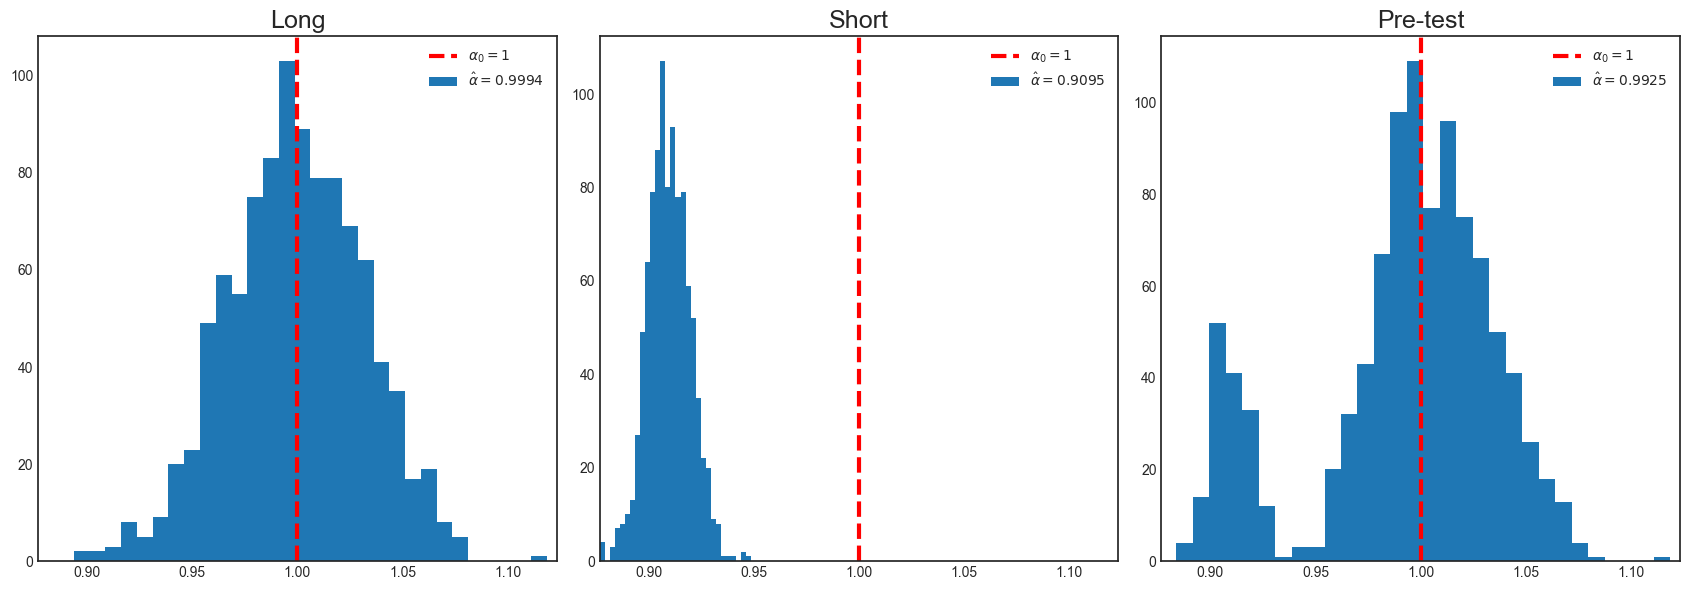

In [20]:
# Plot
plot_alpha(alpha, a)

Como podemos ver, o principal problema do pré-teste é a inferência.

Devido ao procedimento de teste, a distribuição do estimador é uma combinação de duas distribuições diferentes: a resultante da regressão longa e a resultante da regressão curta. O pré-teste não é um problema em 3 casos :

quando
é muito grande: neste caso o teste sempre rejeita a hipótese nula
e sempre executamos a especificação correta, ou seja, a regressão longa

quando
é muito pequeno: neste caso, o teste tem poder muito baixo. No entanto, como vimos na fórmula do Viés da Variável Omitida, o viés é pequeno.

quando
é muito pequeno: também neste caso, o teste tem poder muito baixo. No entanto, como vimos na fórmula do Viés da Variável Omitida, o viés é pequeno.

Vamos comparar as estimativas do pré-teste para diferentes valores do parâmetro verdadeiro
.

In [21]:
# Case 1: different betas and same sample size
b_sequence = b*np.array([0.1,0.3,1,3])
alpha = {}

# Get sequence
for k, b_ in enumerate(b_sequence):
    label = 'beta = %.2f' % b_
    alpha[label] = pre_testing(a, b_, c, n)['Pre-test']
    print('Mean alpha with beta=%.2f: %.4f' % (b_, np.mean(alpha[label])))

Mean alpha with beta=-0.03: 0.9926
Mean alpha with beta=-0.09: 0.9826
Mean alpha with beta=-0.30: 0.9925
Mean alpha with beta=-0.90: 0.9994


As médias são semelhantes, mas vamos analisar as distribuições.

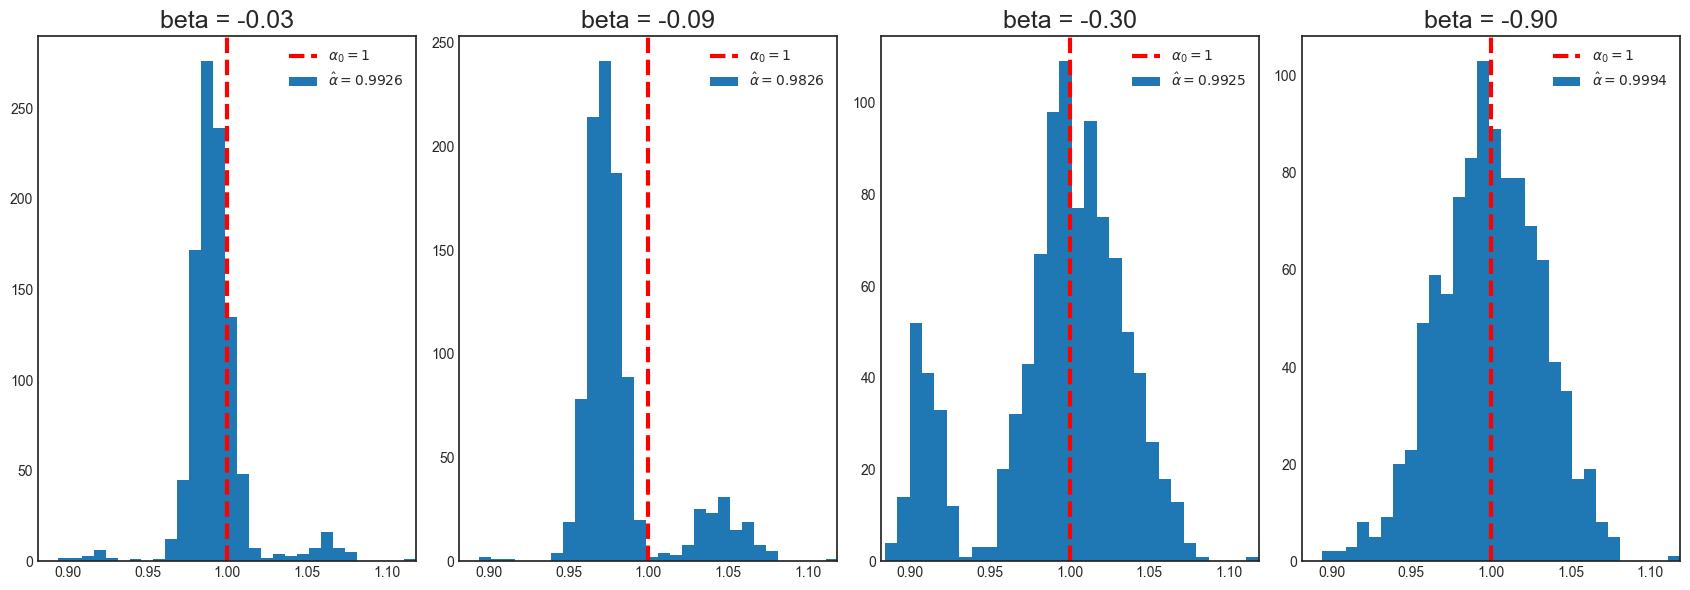

In [22]:
# Plot
plot_alpha(alpha, a)

Quando
é “pequena”, a distribuição do estimador de pré-teste para
não é normal.

No entanto, a magnitude de
é um conceito relativo. Para um tamanho de amostra infinito,
sempre será “grande o suficiente”, no sentido de que com um tamanho de amostra infinito a probabilidade de falsos positivos no teste
vai para zero. Ou seja, sempre selecionamos a especificação correta do modelo, a regressão longa.

Vamos dar uma olhada na distribuição de
quando o tamanho da amostra aumenta.

In [23]:
# Case 2: same beta and different sample sizes
n_sequence = [100,300,1000,3000]
alpha = {}

# Get sequence
for k, n_ in enumerate(n_sequence):
    label = 'n = %.0f' % n_
    alpha[label] = pre_testing(a, b, c, n_)['Pre-test']
    print('Mean alpha with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

Mean alpha with n=100: 0.9442
Mean alpha with n=300: 0.9635
Mean alpha with n=1000: 0.9925
Mean alpha with n=3000: 0.9989


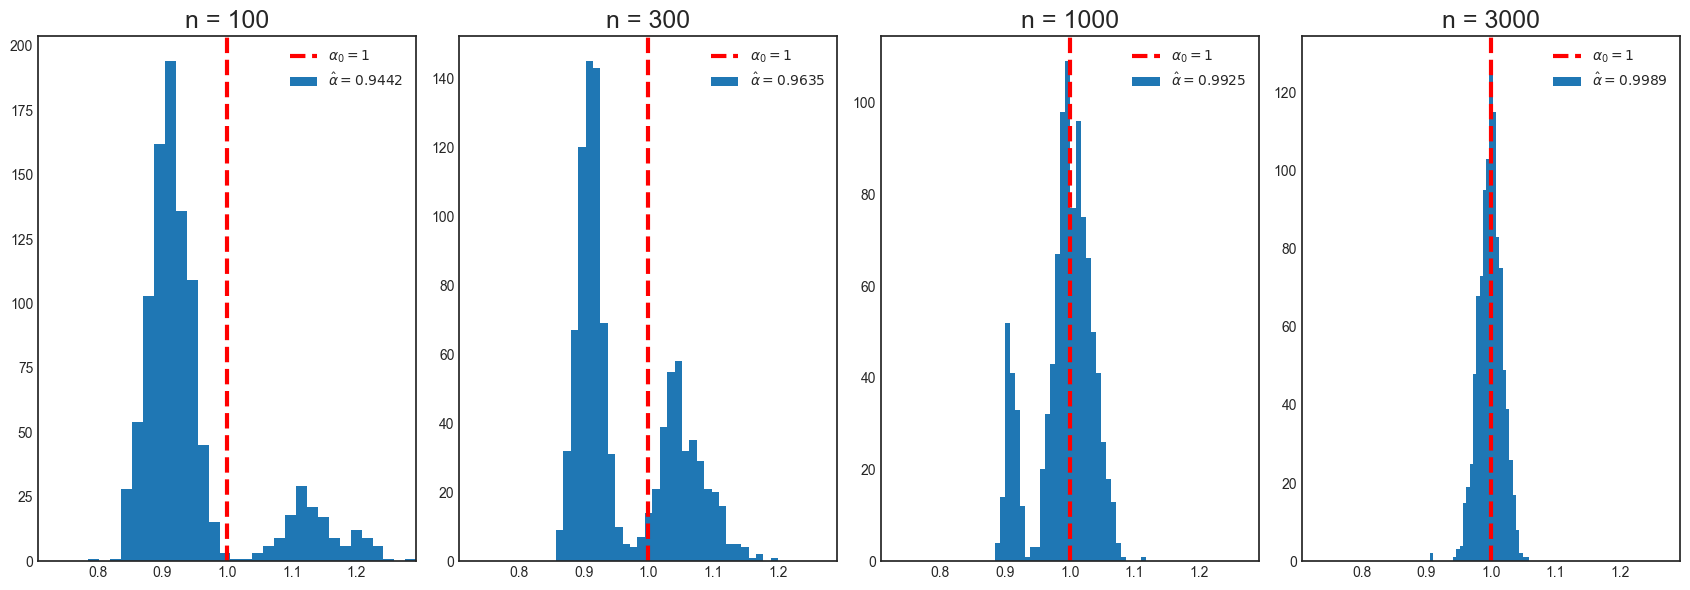

In [24]:
# Plot
plot_alpha(alpha, a)

Como podemos ver, para amostras grandes,
nunca é “pequeno”. No limite, quando
, a probabilidade de falsos positivos durante o teste
vai a zero.

Enfrentamos um dilema:

o pré-teste é claramente um problema em amostras finitas
todos os nossos resultados econométricos são baseados na suposição de que
O problema é resolvido assumindo que o valor de
depende do tamanho da amostra. Isso pode parecer uma suposição estranha, mas serve apenas para ter um conceito assintoticamente significativo de "grande" e "pequeno".

Agora vamos ver o que acontece nas simulações quando
é proporcional a
 
.

In [25]:
# Case 3: beta proportional to 1/sqrt(n) and different sample sizes
beta =  b * 30 / np.sqrt(n_sequence)

# Get sequence
alpha = {}
for k, n_ in enumerate(n_sequence):
    label = 'n = %.0f' % n_
    alpha[label] = pre_testing(a, beta[k], c, n_)['Pre-test']
    print('Mean alpha with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

Mean alpha with n=100: 0.9703
Mean alpha with n=300: 0.9838
Mean alpha with n=1000: 0.9914
Mean alpha with n=3000: 0.9947


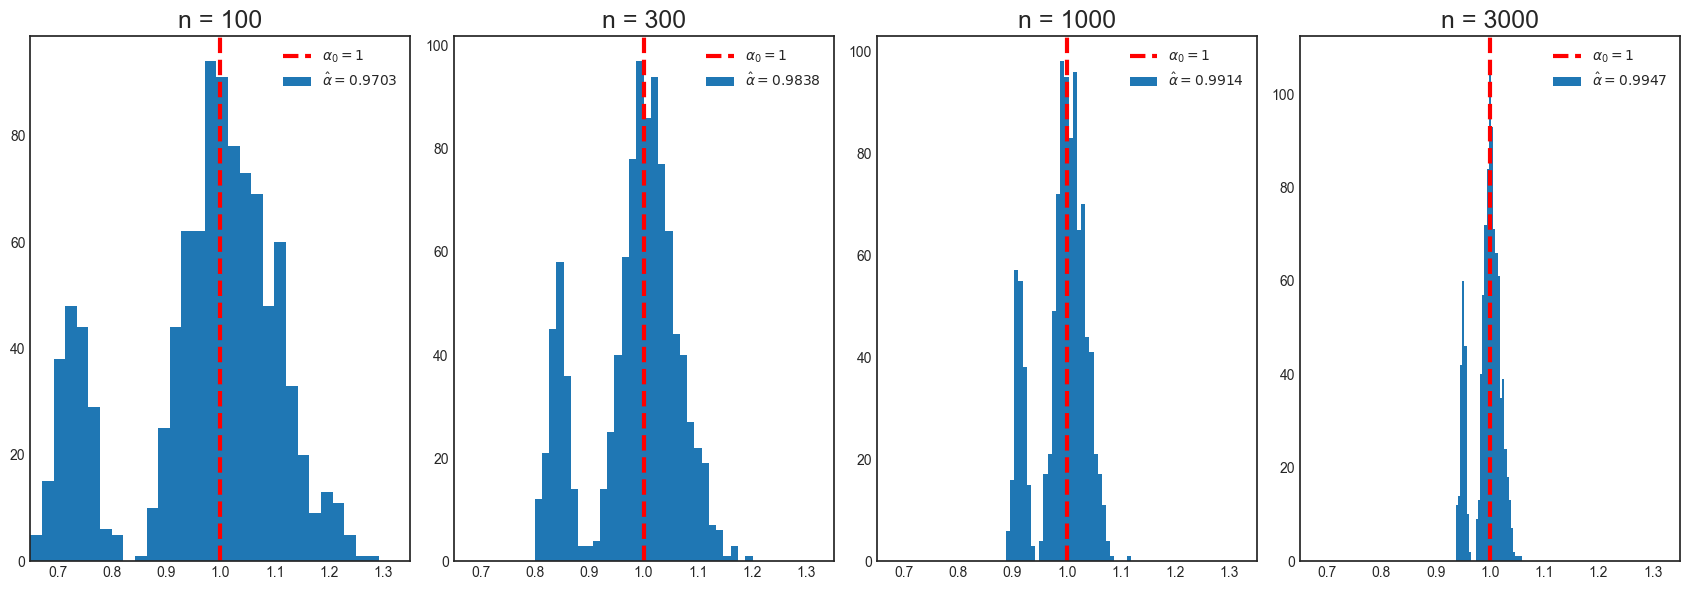

In [26]:
# Plot
plot_alpha(alpha, a)

Agora a distribuição de
não converge para uma normal quando o tamanho da amostra aumenta.

### Pré-teste e aprendizado de máquina

Como o aprendizado de máquina e o pré-teste estão relacionados? O melhor exemplo é o Lasso. Suponha que você tenha um conjunto de dados com muitas variáveis. Isso significa que você tem pouquíssimos graus de liberdade e suas estimativas de Mínimos Quadrados Ordinários (MQO) serão muito imprecisas. No extremo, você tem mais variáveis ​​do que observações, de modo que seu coeficiente de MQO é indefinido, já que não é possível inverter a matriz de design.
.

Nesse caso, talvez você queira fazer a seleção de variáveis. Uma maneira de fazer a seleção de variáveis ​​é por meio de pré-testes. Outra maneira é o Lasso. Uma terceira alternativa é usar métodos de aprendizado de máquina que não sofrem com essa maldição da dimensionalidade.

O propósito e o resultado do pré-teste e do Lasso são os mesmos:

você tem muitas variáveis
você exclui alguns deles da regressão / define seus coeficientes como zero
Como consequência, os problemas também são os mesmos, ou seja, viés pré-teste.

### Pós-Seleção Dupla


Considere novamente os dados
, onde o verdadeiro modelo é:

 

Gostaríamos de nos proteger contra o viés do pré-teste, se possível, para lidar com modelos de alta dimensão. Um bom caminho para motivar procedimentos que protejam contra o viés do pré-teste é uma discussão sobre regressão particionada clássica.

Considere uma regressão
sobre
e
.
é a variável unidimensional de interesse,
é um conjunto de variáveis ​​de controle de alta dimensão. Temos o seguinte procedimento:

Seleção do primeiro estágio : regressão
sobre
. Selecione as variáveis ​​estatisticamente significativas no conjunto
Seleção de forma reduzida : laço
sobre
. Selecione as variáveis ​​estatisticamente significativas no conjunto
Regress
sobre
e
Teorema : Seja
ser uma sequência de processos de geração de dados para
onde
depende de
. Para cada
, os dados são iid com
e
onde
e
. A escassez dos vetores 
,
é controlado por
com
. Suponha que condições de regularidade adicionais nos procedimentos de seleção do modelo e momentos das variáveis ​​aleatórias
,
,
conforme documentado em Belloni et al. (2014). Então, os intervalos de confiança, IC, do procedimento de seleção dupla pós-análise são uniformemente válidos. Ou seja, para qualquer nível de confiança

Para ter intervalos de confiança válidos, você quer que seu viés seja insignificante. Uma vez que
 

Se o viés for
 
então não há problema, pois é assintoticamente desprezível em relação à magnitude do intervalo de confiança. Se, no entanto, o viés for
 
então ele tem a mesma magnitude do intervalo de confiança e não desaparece assintoticamente.

A ideia da demonstração é usar regressão particionada. Uma maneira alternativa de pensar sobre o argumento é: limitar o viés das variáveis ​​omitidas. O viés da variável omitida vem do produto de duas grandezas relacionadas à variável omitida:

Sua correlação parcial com o resultado e
Sua correlação parcial com a variável de interesse.
Se ambas as correlações parciais forem
, então o viés das variáveis ​​omitidas é
 
, oferecido
. Em relação ao
 
taxa de convergência, o viés das variáveis ​​omitidas é insignificante.

No nosso caso de viés de variável omitida, queremos
 
. A seleção pós-dupla garante que

Seleção de forma reduzida (pré-teste): qualquer variável “ausente” tem
 
Seleção de primeiro estágio (adicional): qualquer variável “ausente” tem
 
Como consequência, enquanto o número de variáveis ​​omitidas for finito, o viés da variável omitida é

In [ ]:
# Pre-testing code
def post_double_selection(a, b, c, n, simulations=1000):
    np.random.seed(1)
    
    # Init
    alpha = {'Long': np.zeros((simulations,1)),
            'Short': np.zeros((simulations,1)),
            'Pre-test': np.zeros((simulations,1)),
            'Post-double': np.zeros((simulations,1))}

    # Loop over simulations
    for i in range(simulations):
        
        # Generate data
        x, y, z = generate_data(a, b, c, n)
        
        # Compute coefficients
        xz = np.concatenate([x,z], axis=1)
        alpha['Long'][i] = (inv(xz.T @ xz) @ xz.T @ y)[0][0]
        alpha['Short'][i] = inv(x.T @ x) @ x.T @ y
        
        # Compute significance of z on y (beta hat)
        t1 = t_test(y, xz, 1)
        
        # Compute significance of z on x (gamma hat)
        t2 = t_test(x, z, 0)
        
        # Select specification based on first test
        if np.abs(t1)>1.96:
            alpha['Pre-test'][i] = alpha['Long'][i]
        else:
            alpha['Pre-test'][i] = alpha['Short'][i]
            
        # Select specification based on both tests
        if np.abs(t1)>1.96 or np.abs(t2)>1.96:
            alpha['Post-double'][i] = alpha['Long'][i]
        else:
            alpha['Post-double'][i] = alpha['Short'][i]
    
    return alpha

Vamos agora repetir o mesmo exercício acima, mas também com seleção pós-dupla

In [ ]:
# Get pre_test alpha
alpha = post_double_selection(a, b, c, n)

for key, value in alpha.items():
    print('Mean alpha %s = %.4f' % (key, np.mean(value)))

In [ ]:
# Plot
plot_alpha(alpha, a)

Como podemos ver, a seleção pós-dupla resolveu o problema do pré-teste. Funciona para qualquer magnitude de
(em relação ao tamanho da amostra)?

Primeiro, vamos dar uma olhada no caso em que o tamanho da amostra é fixo e
mudanças.

In [ ]:
# Case 1: different betas and same sample size
b_sequence = b*np.array([0.1,0.3,1,3])
alpha = {}

# Get sequence
for k, b_ in enumerate(b_sequence):
    label = 'beta = %.2f' % b_
    alpha[label] = post_double_selection(a, b_, c, n)['Post-double']
    print('Mean alpha with beta=%.2f: %.4f' % (b_, np.mean(alpha[label])))

In [ ]:
# Plot
plot_alpha(alpha, a)

A seleção pós-dupla sempre seleciona a especificação correta, a regressão longa, mesmo quando
é muito pequeno.

Agora verificamos o mesmo, mas para fixo
e diferentes tamanhos de amostra.

In [ ]:
# Case 2: same beta and different sample sizes
n_sequence = [100,300,1000,3000]
alpha = {}

# Get sequence
for k, n_ in enumerate(n_sequence):
    label = 'N = %.0f' % n_
    alpha[label] = post_double_selection(a, b, c, n_)['Post-double']
    print('Mean alpha with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

In [ ]:
# Plot
plot_alpha(alpha, a)

A pós-seleção dupla sempre seleciona a especificação correta, a regressão longa, mesmo quando o tamanho da amostra é muito pequeno.

Por último, verificamos o caso de
proporcional a
 
.

In [ ]:
# Case 3: beta proportional to 1/sqrt(n) and different sample sizes
beta =  b * 30 / np.sqrt(n_sequence)

# Get sequence
alpha = {}
for k, n_ in enumerate(n_sequence):
    label = 'N = %.0f' % n_
    alpha[label] = post_double_selection(a, beta[k], c, n_)['Post-double']
    print('Mean alpha with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

In [ ]:
# Plot
plot_alpha(alpha, a)

Mais uma vez, a pós-seleção dupla sempre seleciona a especificação correta, a regressão longa.

Pós-seleção dupla e aprendizado de máquina
Como vimos no final da seção anterior, o Lasso pode ser usado para realizar a seleção de variáveis ​​em cenários de alta dimensão. Portanto, a seleção pós-dupla resolve o problema de viés do pré-teste nesses cenários. O procedimento de seleção pós-dupla com o Lasso é:

Seleção da primeira fase : laço
sobre
. Deixe que as variáveis ​​selecionadas sejam coletadas no conjunto
Seleção de forma reduzida : laço
sobre
. Deixe que as variáveis ​​selecionadas sejam coletadas no conjunto
Regress
sobre
e

### Aprendizado de máquina duplo/desviés

Esta seção foi retirada de Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W., & Robins, J. (2018). “ Aprendizado de máquina duplo/desviado para tratamento e parâmetros estruturais ” .

Considere o seguinte modelo parcialmente linear


onde
é a variável de resultado,
é o tratamento de interesse e
é um conjunto de controles potencialmente de alta dimensão.

Abordagem ingênua
Uma abordagem ingênua para estimativa de
usar métodos de ML seria, por exemplo, construir um estimador de ML sofisticado
para aprender a função de regressão
+
.

Divida a amostra em duas: amostra principal e amostra auxiliar
Use a amostra auxiliar para estimar
Use a amostra principal para calcular o componente ortogonalizado de
sobre
: $\que u = \esquerda(Y_{i}-\que{g} {0}\esquerda(X {i}\direita)\direita)$
Use a amostra principal para estimar o estimador MCO residualizado
$$ \que{\beta} {0}=\esquerda(\frac{1}{n} \soma {i \em I} D_{i}^{2}\direita)^{-1} \frac{1}{n} \soma_{i \em I} D_{i} \que u_i $$

Este estimador terá dois problemas:

Taxa de convergência lenta, ou seja, mais lenta que
Será tendencioso porque estamos empregando estimadores regularizados de alta dimensão (por exemplo, estamos fazendo seleção de variáveis)
Ortogonalização
Agora considere uma segunda construção que emprega uma formulação ortogonalizada obtida pela parcialização direta do efeito de
de
para obter o regressor ortogonalizado
.

Divida a amostra em duas: amostra principal e amostra auxiliar

Use a amostra auxiliar para estimar
de


Use a amostra auxiliar para estimar
de


Use a amostra principal para calcular o componente ortogonalizado de
sobre
como


Use a amostra principal para estimar o estimador OLS duplamente residualizado como

$$ \que{\beta} {0}=\esquerda(\frac{1}{n} \soma {i \em I} \que v_i D_{i} \direita)^{-1} \frac{1}{n} \soma_{i \em I} \que v_i \esquerda( Y - \que g_0(X) \direita) $$

O estimador é imparcial, mas ainda apresenta uma taxa de convergência menor devido à divisão da amostra. O problema é resolvido invertendo a amostra dividida, reestimando o coeficiente e calculando a média das duas estimativas. Observe que este procedimento é válido, pois as duas estimativas são independentes pelo procedimento de divisão da amostra.

Aplicação para AJR02
Nesta seção, replicaremos 6.3 do artigo “ Aprendizado de máquina duplo/desviado ” baseado em Acemoglu, Johnson, Robinson (2002), “ As origens coloniais do desenvolvimento comparativo ” .

Primeiro carregamos o conjunto de dados

In [ ]:
# Load Acemoglu Johnson Robinson Dataset
df = pd.read_csv('data/AJR02.csv',index_col=0)
df.head()

In [ ]:
df.info()

Em seu artigo, a AJR observa que sua estratégia de IV será invalidada se outros fatores também forem altamente persistentes e relacionados ao desenvolvimento das instituições dentro de um país e ao PIB do país. Um dos principais candidatos a tal fator, como eles discutem, é a geografia. A AJR aborda isso assumindo que o efeito de confusão da geografia é adequadamente capturado por um termo linear de distância do equador e um conjunto de variáveis ​​fictícias continentais.

Eles incluem seus resultados na tabela 2.

In [ ]:
# Add constant term to dataset
df['const'] = 1

# Create lists of variables to be used in each regression
X1 = df[['const', 'Exprop']]
X2 = df[['const', 'Exprop', 'Latitude', 'Latitude2']]
X3 = df[['const', 'Exprop', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer']]
y = df['GDP']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(y, X1, missing='drop').fit()
reg2 = sm.OLS(y, X2, missing='drop').fit()
reg3 = sm.OLS(y, X3, missing='drop').fit()

Vamos replicar a Tabela 2 no AJR.

In [ ]:
# Make table 2
def make_table_2():

    info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

    results_table = summary_col(results=[reg1,reg2,reg3],
                                float_format='%0.2f',
                                stars = True,
                                model_names=['Model 1','Model 2','Model 3'],
                                info_dict=info_dict,
                                regressor_order=['const','Exprop','Latitude','Latitude2'])
    return results_table

In [ ]:
table_2 = make_table_2()
table_2

Usar DML nos permite relaxar essa suposição e substituí-la por uma suposição mais fraca de que a geografia pode ser suficientemente controlada por uma função desconhecida de distância do equador e de modelos continentais, o que pode ser aprendido por métodos de ML.

Em particular, a nossa estrutura é


Para que o procedimento de aprendizagem de máquina duplo/desviés seja

Divida a amostra em duas: amostra principal e amostra auxiliar

Use a amostra auxiliar para estimar
de


Use a amostra auxiliar para estimar
de


Use a amostra principal para calcular o componente ortogonalizado de
sobre
como


Use a amostra principal para estimar o estimador OLS duplamente residualizado como

$$ \hat{\beta} {0}=\left(\frac{1}{n} \sum {i \in I} \hat v_i \times {Exprop} {i} \right)^{-1} \frac{1}{n} \sum {i \in I} \hat v_i \times \left( {PIB} - \hat g_0({geografia}) \right) $$

Como empregamos uma estratégia de variável instrumental , substituímos
com
no primeiro estágio.

In [ ]:
# Generate variables
D = df['Exprop'].values.reshape(-1,1)
X = df[['const', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer']].values
y = df['GDP'].values.reshape(-1,1)
Z = df[['const', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer','logMort']].values

In [ ]:
def estimate_beta(algorithm, alg_name, D, X, y, Z, sample):

    # Split sample
    D_main, D_aux = (D[sample==1], D[sample==0])
    X_main, X_aux = (X[sample==1], X[sample==0])
    y_main, y_aux = (y[sample==1], y[sample==0])
    Z_main, Z_aux = (Z[sample==1], Z[sample==0])

    # Residualize y on D
    b_hat = inv(D_aux.T @ D_aux) @ D_aux.T @ y_aux
    y_resid_aux = y_aux - D_aux @ b_hat
    
    # Estimate g0
    alg_fitted = algorithm.fit(X=X_aux, y=y_resid_aux.ravel())
    g0 = alg_fitted.predict(X_main).reshape(-1,1)

    # Compute v_hat
    u_hat = y_main - g0

    # Estimate m0
    alg_fitted = algorithm.fit(X=Z_aux, y=D_aux.ravel())
    m0 = algorithm.predict(Z_main).reshape(-1,1)
    
    # Compute u_hat
    v_hat = D_main - m0

    # Estimate beta
    beta = inv(v_hat.T @ D_main) @ v_hat.T @ u_hat
        
    return beta 

In [ ]:
def ddml(algorithm, alg_name, D, X, y, Z, p=0.5, verbose=False):
    
    # Expand X if Lasso or Ridge
    if alg_name in ['Lasso   ','Ridge   ']:
        X = PolynomialFeatures(degree=2).fit_transform(X)

    # Generate split (fixed proportions)
    split = np.array([i in train_test_split(range(len(D)), test_size=p)[0] for i in range(len(D))])
    
    # Compute beta
    beta = [estimate_beta(algorithm, alg_name, D, X, y, Z, split==k) for k in range(2)]
    beta = np.mean(beta)
     
    # Print and return
    if verbose:
        print('%s : %.4f' % (alg_name, beta))
    return beta

In [ ]:
# Generate sample split
p = 0.5
split = np.random.binomial(1, p, len(D))

Inspecionamos diferentes algoritmos. Em particular, consideramos:

Regressão Lasso
Regressão de Ridge
Árvores de Regressão
Floresta aleatória
Florestas Impulsionadas

In [ ]:
# List all algorithms
algorithms = {'Ridge   ': Ridge(alpha=.1),
              'Lasso   ': Lasso(alpha=.01),
              'Tree    ': DecisionTreeRegressor(),
              'Forest  ': RandomForestRegressor(n_estimators=30),
              'Boosting': GradientBoostingRegressor(n_estimators=30)}

Vamos comparar os resultados.

In [ ]:
# Loop over algorithms
for alg_name, algorithm in algorithms.items():
    ddml(algorithm, alg_name, D, X, y, Z, verbose=True)

Os resultados são extremamente voláteis.

In [ ]:
# Repeat K times
def estimate_beta_median(algorithms, D, X, y, Z, K):
    
    # Loop over algorithms
    for alg_name, algorithm in algorithms.items():
        betas = []
            
        # Iterate n times
        for k in range(K):
            beta = ddml(algorithm, alg_name, D, X, y, Z)
            betas = np.append(betas, beta)
    
        print('%s : %.4f' % (alg_name, np.median(betas)))

Vamos tentar usar a mediana para ter um estimador mais estável.

In [ ]:
np.random.seed(123)

# Repeat 100 times and take median
estimate_beta_median(algorithms, D, X, y, Z, 100)

Os resultados diferem um pouco dos do artigo, mas pelo menos são mais próximos.

In [1]:
# Pacotes
import numpy as np
import pandas as pd
import plotnine as p
import statsmodels.api as sm
import linearmodels as lm
import statsmodels.formula.api as smf 
from linearmodels.panel import PanelOLS
from statsmodels.iolib.summary2 import summary_col

In [2]:
# Carregar a base de dados
data = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/bacon_example.dta")

In [ ]:
# Filtragem dos dados
# Vamos criar identificadores estaduais
data['id'] = data['stfips'].rank(method='dense').astype(int)

# Criar uma nova variável de tempo "time"
data['time'] = data['year'] - 1963

# Time to treatment
data['year_treated'] = data['_nfd']
data['time_to_treatment'] = data['year'] - data['year_treated'] + 1

# Outcome (Suicide Mortality)
data['Y'] = data['asmrs']
# Treatment
data['D'] = data['post']
# Covariáveis - pcinc asmrh cases
data['X1'] = data['pcinc']
data['X2'] = data['asmrh']
data['X3'] = data['cases']


data['media_D'] = data.groupby('id')['D'].transform('mean')
data['always_treated'] = np.where(data['media_D'] == 1, 1, 0)
data['never_treated'] = np.where(data['media_D'] == 0, 1, 0)

# Vamos criar a variável de grupo G
data['G']=data['_nfd']



In [15]:
data

stfips    year    _nfd  post      asmrs         pcinc     asmrh  \
id1 year1                                                                    
1   1964        1  1964.0  1971.0   0.0  35.639885  12406.178537  5.007341   
    1965        1  1965.0  1971.0   0.0  41.543755  13070.206738  4.425367   
    1966        1  1966.0  1971.0   0.0  34.252335  13526.663217  4.874819   
    1967        1  1967.0  1971.0   0.0  34.465023  13918.189823  5.362014   
    1968        1  1968.0  1971.0   0.0  40.440105  14684.808682  4.643759   
...           ...     ...     ...   ...        ...           ...       ...   
49  1992       56  1992.0  1977.0   1.0  33.149574  31181.450546  1.970134   
    1993       56  1993.0  1977.0   1.0  63.909775  31666.776231  3.020953   
    1994       56  1994.0  1977.0   1.0  81.793816  31959.528356  3.501871   
    1995       56  1995.0  1977.0   1.0  30.630585  32327.659531  0.740606   
    1996       56  1996.0  1977.0   1.0  49.669003  32667.248279  2.663140   

              cases        weight         copop  ...    D            X1  \
id1 year1                                        ...                      
1   1964   0.012312  1.715156e+06  1.715156e+06  ...  0.0  12406.178537   
    1965   0.010419  1.715156e+06  1.725186e+06  ...  0.0  13070.206738   
    1966   0.009900  1.715156e+06  1.735219e+06  ...  0.0  13526.663217   
    1967   0.009975  1.715156e+06  1.745250e+06  ...  0.0  13918.189823   
    1968   0.012401  1.715156e+06  1.755283e+06  ...  0.0  14684.808682   
...             ...           ...           ...  ...  ...           ...   
49  1992   0.028996  1.621688e+05  2.323830e+05  ...  1.0  31181.450546   
    1993   0.026672  1.621688e+05  2.355600e+05  ...  1.0  31666.776231   
    1994   0.023643  1.621688e+05  2.389800e+05  ...  1.0  31959.528356   
    1995   0.020965  1.621688e+05  2.414090e+05  ...  1.0  32327.659531   
    1996   0.018639  1.621688e+05  2.429100e+05  ...  1.0  32667.248279   

                 X2        X3   media_D  always_treated  never_treated  \
id1 year1                                                                
1   1964   5.007341  0.012312  0.787879               0              0   
    1965   4.425367  0.010419  0.787879               0              0   
    1966   4.874819  0.009900  0.787879               0              0   
    1967   5.362014  0.009975  0.787879               0              0   
    1968   4.643759  0.012401  0.787879               0              0   
...             ...       ...       ...             ...            ...   
49  1992   1.970134  0.028996  0.606061               0              0   
    1993   3.020953  0.026672  0.606061               0              0   
    1994   3.501871  0.023643  0.606061               0              0   
    1995   0.740606  0.020965  0.606061               0              0   
    1996   2.663140  0.018639  0.606061               0              0   

           time_to_treatment  year_treated       G  
id1 year1                                           
1   1964                -6.0        1971.0  1971.0  
    1965                -5.0        1971.0  1971.0  
    1966                -4.0        1971.0  1971.0  
    1967                -3.0        1971.0  1971.0  
    1968                -2.0        1971.0  1971.0  
...                      ...           ...     ...  
49  1992                16.0        1977.0  1977.0  
    1993                17.0        1977.0  1977.0  
    1994                18.0        1977.0  1977.0  
    1995                19.0        1977.0  1977.0  
    1996                20.0        1977.0  1977.0  

[1617 rows x 23 columns]

In [16]:
# estrutura de painel dos dados. Precisamos ajustar a variável year para int (inteiro)
# Criando clones
data['year1'] = data['year']
data['id1'] = data['id']
data['year1'] = data['year'].astype(int)

# Definir os indices (estrutura de painel)
data.set_index(['id1', 'year1'], inplace=True)

In [18]:
import pandas as pd
from differences import ATTgt
import numpy as np

In [19]:
att_gt = ATTgt(data=data, cohort_name="G")

In [20]:
att_gt.fit("Y ~ X1", est_method="dr")

Computing ATTgt [workers=1]   100%|████████████████████| 384/384 [00:04<00:00, 93.44it/s] 


ATTgtResult                                            \
                                     analytic pointwise conf. band              
                                ATT std_error                lower      upper   
cohort base_period time                                                         
1969   1964        1965   -6.070418  8.259573           -22.258884  10.118048   
       1965        1966    6.174149  9.094903           -11.651533  23.999831   
       1966        1967    5.848175  3.752705            -1.506991  13.203342   
       1967        1968    2.036093  2.414729            -2.696688   6.768875   
       1968        1969    1.558169  4.865841            -7.978705  11.095043   
...                             ...       ...                  ...        ...   
1985   1984        1992   19.930538  4.051701            11.989349  27.871726   
                   1993   16.124177  2.333263            11.551066  20.697287   
                   1994   11.830665  2.834945             6.274274  17.387055   
                   1995    8.493860  2.493009             3.607652  13.380068   
                   1996   20.431504  4.480529            11.649828  29.213179   

                                           
                                           
                        zero_not_in_cband  
cohort base_period time                    
1969   1964        1965                    
       1965        1966                    
       1966        1967                    
       1967        1968                    
       1968        1969                    
...                                   ...  
1985   1984        1992                 *  
                   1993                 *  
                   1994                 *  
                   1995                 *  
                   1996                 *  

[384 rows x 5 columns]

In [21]:
att_gt.aggregate("simple")

SimpleAggregation                                                           
                     analytic pointwise conf. band                            
                ATT std_error                lower     upper zero_not_in_cband
0         -5.983104  3.130347           -12.118472  0.152264

In [22]:
att_gt.aggregate("event")

EventAggregation                                             \
                                   analytic pointwise conf. band              
                             ATT  std_error                lower      upper   
relative_period                                                               
-20                    -5.033935   3.389414           -11.677064   1.609194   
-19                    20.493741  15.162160            -9.223546  50.211027   
-18                   -16.704148   7.497377           -31.398738  -2.009559   
-17                     6.379153  10.724160           -14.639815  27.398121   
-16                     0.227519   5.676934           -10.899067  11.354106   
-15                     1.996730   5.853899            -9.476702  13.470162   
-14                     1.966673   3.972759            -5.819790   9.753137   
-13                     1.981498   5.786478            -9.359792  13.322787   
-12                    -4.305008   8.346027           -20.662921  12.052905   
-11                   -12.235455   7.406652           -26.752226   2.281317   
-10                    12.658956   6.745294            -0.561577  25.879489   
-9                     -8.502006   4.483655           -17.289809   0.285796   
-8                      2.087717   2.709509            -3.222824   7.398258   
-7                     -0.561912   3.277482            -6.985659   5.861835   
-6                      1.489753   3.421874            -5.216996   8.196502   
-5                     -2.400586   2.678888            -7.651110   2.849938   
-4                      3.071620   2.164289            -1.170308   7.313548   
-3                      0.273076   2.473907            -4.575692   5.121844   
-2                      0.375515   2.706088            -4.928321   5.679351   
-1                      0.897422   2.960048            -4.904165   6.699010   
 0                     -1.025316   2.684484            -6.286808   4.236176   
 1                     -1.924231   3.206853            -8.209548   4.361087   
 2                     -3.342883   3.887112           -10.961482   4.275716   
 3                     -2.098534   2.944012            -7.868691   3.671622   
 4                     -3.398965   2.720592            -8.731228   1.933297   
 5                     -4.233076   3.248700           -10.600410   2.134259   
 6                     -4.123248   3.441458           -10.868381   2.621886   
 7                     -6.625254   3.938525           -14.344621   1.094113   
 8                     -7.242188   3.076394           -13.271809  -1.212566   
 9                     -3.863612   4.015843           -11.734519   4.007296   
 10                    -7.074051   4.059642           -15.030804   0.882702   
 11                    -4.193251   4.396948           -12.811111   4.424609   
 12                    -3.624977   4.172082           -11.802108   4.552154   
 13                    -5.242709   4.489746           -14.042450   3.557032   
 14                    -4.248161   4.679667           -13.420139   4.923818   
 15                    -6.474832   4.595357           -15.481567   2.531903   
 16                    -5.952079   4.229266           -14.241288   2.337130   
 17                    -7.172010   4.582262           -16.153079   1.809059   
 18                    -8.961597   4.027966           -16.856264  -1.066929   
 19                   -10.507467   3.690032           -17.739797  -3.275137   
 20                    -8.203524   4.103070           -16.245395  -0.161654   
 21                    -9.381068   3.973210           -17.168417  -1.593719   
 22                   -10.708308   3.914203           -18.380005  -3.036611   
 23                   -12.198167   4.139249           -20.310946  -4.085387   
 24                   -13.166945   4.942369           -22.853811  -3.480079   
 25                   -13.419991   6.880288           -26.905108   0.065126   
 26                   -22.371152  11.263488           -44.447182  

In [25]:
# Pacotes
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Filtrar apenas grupos tratados e nunca tratados
data_cf = data[(data['never_treated'] == 1) | (data['always_treated'] == 0)]

# Definir variáveis
Y = data_cf['Y'].values
T = data_cf['D'].astype(int).values
X = data_cf[['X1', 'X2', 'X3']].values

# Padronizar as covariáveis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Estimar Causal Forest
causal_forest = CausalForestDML(
    model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
    model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
    n_estimators=500,
    min_samples_leaf=5,
    max_depth=10,
    verbose=1,
    random_state=42
)

causal_forest.fit(Y, T, X=X_scaled)

# Estimar efeito médio do tratamento (ATE)
ate = causal_forest.ate_
print(f"ATE: {ate:.4f}")

# Estimar CATEs individuais
cate_preds = causal_forest.effect(X_scaled)

# Adicionar os efeitos de tratamento ao DataFrame
data_cf['CATE'] = cate_preds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


AttributeError: Doubly Robust ATE calculation on training data is available only on discrete treatments!

In [24]:
data_cf

stfips    year    _nfd  post      asmrs         pcinc     asmrh  \
id1 year1                                                                    
1   1964        1  1964.0  1971.0   0.0  35.639885  12406.178537  5.007341   
    1965        1  1965.0  1971.0   0.0  41.543755  13070.206738  4.425367   
    1966        1  1966.0  1971.0   0.0  34.252335  13526.663217  4.874819   
    1967        1  1967.0  1971.0   0.0  34.465023  13918.189823  5.362014   
    1968        1  1968.0  1971.0   0.0  40.440105  14684.808682  4.643759   
...           ...     ...     ...   ...        ...           ...       ...   
49  1992       56  1992.0  1977.0   1.0  33.149574  31181.450546  1.970134   
    1993       56  1993.0  1977.0   1.0  63.909775  31666.776231  3.020953   
    1994       56  1994.0  1977.0   1.0  81.793816  31959.528356  3.501871   
    1995       56  1995.0  1977.0   1.0  30.630585  32327.659531  0.740606   
    1996       56  1996.0  1977.0   1.0  49.669003  32667.248279  2.663140   

              cases        weight         copop  ...    D            X1  \
id1 year1                                        ...                      
1   1964   0.012312  1.715156e+06  1.715156e+06  ...  0.0  12406.178537   
    1965   0.010419  1.715156e+06  1.725186e+06  ...  0.0  13070.206738   
    1966   0.009900  1.715156e+06  1.735219e+06  ...  0.0  13526.663217   
    1967   0.009975  1.715156e+06  1.745250e+06  ...  0.0  13918.189823   
    1968   0.012401  1.715156e+06  1.755283e+06  ...  0.0  14684.808682   
...             ...           ...           ...  ...  ...           ...   
49  1992   0.028996  1.621688e+05  2.323830e+05  ...  1.0  31181.450546   
    1993   0.026672  1.621688e+05  2.355600e+05  ...  1.0  31666.776231   
    1994   0.023643  1.621688e+05  2.389800e+05  ...  1.0  31959.528356   
    1995   0.020965  1.621688e+05  2.414090e+05  ...  1.0  32327.659531   
    1996   0.018639  1.621688e+05  2.429100e+05  ...  1.0  32667.248279   

                 X2        X3   media_D  always_treated  never_treated  \
id1 year1                                                                
1   1964   5.007341  0.012312  0.787879               0              0   
    1965   4.425367  0.010419  0.787879               0              0   
    1966   4.874819  0.009900  0.787879               0              0   
    1967   5.362014  0.009975  0.787879               0              0   
    1968   4.643759  0.012401  0.787879               0              0   
...             ...       ...       ...             ...            ...   
49  1992   1.970134  0.028996  0.606061               0              0   
    1993   3.020953  0.026672  0.606061               0              0   
    1994   3.501871  0.023643  0.606061               0              0   
    1995   0.740606  0.020965  0.606061               0              0   
    1996   2.663140  0.018639  0.606061               0              0   

           time_to_treatment  year_treated       G  
id1 year1                                           
1   1964                -6.0        1971.0  1971.0  
    1965                -5.0        1971.0  1971.0  
    1966                -4.0        1971.0  1971.0  
    1967                -3.0        1971.0  1971.0  
    1968                -2.0        1971.0  1971.0  
...                      ...           ...     ...  
49  1992                16.0        1977.0  1977.0  
    1993                17.0        1977.0  1977.0  
    1994                18.0        1977.0  1977.0  
    1995                19.0        1977.0  1977.0  
    1996                20.0        1977.0  1977.0  

[1353 rows x 23 columns]